This is the notebook where the datasets are imported as dataframes. From merging to cleaning (yes, even more cleaning) to splitting, it is all done here. Enjoy the process.

In [1]:
# importing all the required packages
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import isnan
from datetime import datetime, timedelta
import pytz  
import glob
import os
%matplotlib inline

### Extracting ERA5 data for each city

 This needs a little more processing, as each file contains information on up to 9 longitude and latitude combinations. We are only interested in only combination per city. 

In [3]:
def load_and_aggregate_era5(csv_path, city_name, lat_center, lon_center):
    """
    Loads ERA5 CSV for a city, filters to ±0.1° bounding box,
    and returns averaged hourly weather data across grid cells.
    """
    print(f"Processing ERA5 for {city_name}...")

    df = pd.read_csv(csv_path)
    df['valid_time'] = pd.to_datetime(df['valid_time'], utc=True)

    lat_min, lat_max = lat_center - 0.1, lat_center + 0.1
    lon_min, lon_max = lon_center - 0.1, lon_center + 0.1

    df_filtered = df[
        (df['latitude'].between(lat_min, lat_max)) &
        (df['longitude'].between(lon_min, lon_max))
    ].copy()

    if df_filtered.empty:
        print(f"⚠️ Warning: No ERA5 data found within bounding box for {city_name}")
        return pd.DataFrame()

    df_grouped = df_filtered.groupby('valid_time')[
        ['t2m', 'u10', 'v10', 'd2m', 'tp']
    ].mean().reset_index()

    return df_grouped

In [4]:
# Lagos
era5_df_lagos = load_and_aggregate_era5(
    csv_path=r"Datasets/ERAdata_4/Lagos_ERA5.csv",
    city_name="Lagos",
    lat_center=6.45,
    lon_center=3.39
)

# Abuja
era5_df_abuja = load_and_aggregate_era5(
    csv_path=r"Datasets/ERAdata_4/Abuja_ERA5.csv",
    city_name="Abuja",
    lat_center=9.06,
    lon_center=7.50
)

# Chennai
era5_df_chennai = load_and_aggregate_era5(
    csv_path=r"Datasets/ERAdata_4/Chennai_ERA5.csv",
    city_name="Chennai",
    lat_center=13.08,
    lon_center=80.28
)

# New Delhi
era5_df_newdelhi = load_and_aggregate_era5(
    csv_path=r"Datasets/ERAdata_4/NewDelhi_ERA5.csv",
    city_name="New_Delhi",
    lat_center=28.61,
    lon_center=77.23
)

Processing ERA5 for Lagos...
Processing ERA5 for Abuja...
Processing ERA5 for Chennai...
Processing ERA5 for New_Delhi...


In [5]:
# viewing the last few rows of New Delhi DataFrame
print("New Delhi ERA5 DataFrame:")
print(era5_df_newdelhi.tail())

New Delhi ERA5 DataFrame:
                     valid_time         t2m       u10       v10         d2m  \
38847 2025-06-07 15:00:00+00:00  306.092453 -2.116869 -0.899417  293.491532   
38848 2025-06-07 16:00:00+00:00  304.983193 -2.287991  0.285734  293.756345   
38849 2025-06-07 17:00:00+00:00  304.050593 -1.866207  1.170132  293.917553   
38850 2025-06-07 18:00:00+00:00  303.275492 -1.159193  1.894119  294.001372   
38851 2025-06-07 19:00:00+00:00  303.437875 -0.679571  2.369744  293.714150   

                 tp  
38847  4.410744e-07  
38848  4.410744e-07  
38849  4.410744e-07  
38850  4.410744e-07  
38851  4.410744e-07  


### Extracting VIIRS nightime light data for each city

In [6]:
virrs_Abuja_df = pd.read_csv(r"Datasets\viirs_city_csvs\Abuja.csv", parse_dates=['date'])
virrs_lagos_df = pd.read_csv(r"Datasets\viirs_city_csvs\Lagos.csv", parse_dates=['date'])
virrs_chennai_df = pd.read_csv(r"Datasets\viirs_city_csvs\Chennai.csv", parse_dates=['date'])
virrs_newdelhi_df = pd.read_csv(r"Datasets\viirs_city_csvs\New_Delhi.csv", parse_dates=['date'])

#viewing the first few rows for Abuja
virrs_Abuja_df.head()

,date,timestamp_utc,city_lat,city_lon,DNB_at_sensor_rad,radiance_5x5_avg,background_21x21,Radiance_M10,cloud_mask_QF,solar_zenith_deg,solar_azimuth_deg,lunar_zenith_deg,lunar_azimuth_deg,moon_illum_frac,sensor_zenith_deg,sensor_azimuth_deg
0,2021-01-01,2021-01-01T01:48:35.149212,9.06,7.5,36.609478,31.987862,27.589436,31.0,50,144.70,117.49,26.21,-50.57,99.10,65.11,-78.80
1,2021-01-02,2021-01-02T01:29:48.124895,9.06,7.5,36.261990,30.578772,24.660868,31.0,50,148.89,120.11,14.61,-15.26,96.08,49.25,-79.72
2,2021-01-03,2021-01-03T01:10:59.767199,9.06,7.5,28.884558,28.297535,22.862431,31.0,50,152.98,123.71,17.21,48.04,90.93,21.45,-80.08
3,2021-01-04,2021-01-04T00:52:10.403996,9.06,7.5,25.409077,29.957790,22.808472,31.0,50,156.87,128.78,30.89,73.46,83.79,17.16,99.26
4,2021-01-05,2021-01-05T00:33:20.151157,9.06,7.5,35.901993,29.348921,25.214830,31.0,50,160.46,136.04,46.92,82.86,74.96,46.80,98.07


In [7]:
#check which dates are missing in the VIIRS data
def check_missing_dates(viirs_df, start_date, end_date):
    """
    Checks for missing dates in the VIIRS DataFrame.
    Returns a list of missing dates.
    """
    all_dates = pd.date_range(start=start_date, end=end_date, freq='D')
    viirs_dates = pd.to_datetime(viirs_df['date']).dt.date.unique()
    
    missing_dates = [date for date in all_dates if date not in viirs_dates]
    
    return missing_dates
# Check for missing dates in each city's VIIRS data
start_date = '2021-01-01'
end_date = '2025-01-31'
missing_dates_abuja = check_missing_dates(virrs_Abuja_df, start_date, end_date)
missing_dates_lagos = check_missing_dates(virrs_lagos_df, start_date, end_date)
missing_dates_chennai = check_missing_dates(virrs_chennai_df, start_date, end_date)
missing_dates_newdelhi = check_missing_dates(virrs_newdelhi_df, start_date, end_date)
# Print missing dates for each city 
print(f"Missing dates in Abuja VIIRS data: {missing_dates_abuja}")
print(f"Missing dates in Lagos VIIRS data: {missing_dates_lagos}")
print(f"Missing dates in Chennai VIIRS data: {missing_dates_chennai}")
print(f"Missing dates in New Delhi VIIRS data: {missing_dates_newdelhi}")

Missing dates in Abuja VIIRS data: [Timestamp('2021-01-01 00:00:00'), Timestamp('2021-01-02 00:00:00'), Timestamp('2021-01-03 00:00:00'), Timestamp('2021-01-04 00:00:00'), Timestamp('2021-01-05 00:00:00'), Timestamp('2021-01-06 00:00:00'), Timestamp('2021-01-07 00:00:00'), Timestamp('2021-01-08 00:00:00'), Timestamp('2021-01-09 00:00:00'), Timestamp('2021-01-10 00:00:00'), Timestamp('2021-01-11 00:00:00'), Timestamp('2021-01-12 00:00:00'), Timestamp('2021-01-13 00:00:00'), Timestamp('2021-01-14 00:00:00'), Timestamp('2021-01-15 00:00:00'), Timestamp('2021-01-16 00:00:00'), Timestamp('2021-01-17 00:00:00'), Timestamp('2021-01-18 00:00:00'), Timestamp('2021-01-19 00:00:00'), Timestamp('2021-01-20 00:00:00'), Timestamp('2021-01-21 00:00:00'), Timestamp('2021-01-22 00:00:00'), Timestamp('2021-01-23 00:00:00'), Timestamp('2021-01-24 00:00:00'), Timestamp('2021-01-25 00:00:00'), Timestamp('2021-01-26 00:00:00'), Timestamp('2021-01-27 00:00:00'), Timestamp('2021-01-28 00:00:00'), Timestamp('2

### PM2.5 Data Processing and Extraction

In [8]:
#first we will combine the 5 yearly files for each city into one file:

pm25_abuja_df = pd.concat([pd.read_csv(f) for f in sorted (glob.glob(r"Datasets/PM25/Abuja_*.csv"))], ignore_index=True)

# Convert date-time column to datetime format
pm25_abuja_df['datetime'] = pd.to_datetime(pm25_abuja_df['Date (LT)'], errors='coerce')

# Repeat for other cities:
pm25_lagos_df = pd.concat([pd.read_csv(f) for f in sorted(glob.glob(r"Datasets/PM25/Lagos_*.csv"))], ignore_index=True)
pm25_lagos_df['datetime'] = pd.to_datetime(pm25_lagos_df['Date (LT)'], errors='coerce')

pm25_chennai_df = pd.concat([pd.read_csv(f) for f in sorted(glob.glob(r"Datasets/PM25/Chennai_*.csv"))], ignore_index=True)
pm25_chennai_df['datetime'] = pd.to_datetime(pm25_chennai_df['Date (LT)'], errors='coerce')

pm25_newdelhi_df = pd.concat([pd.read_csv(f) for f in sorted(glob.glob(r"Datasets/PM25/NewDelhi_*.csv"))], ignore_index=True)
pm25_newdelhi_df['datetime'] = pd.to_datetime(pm25_newdelhi_df['Date (LT)'], errors='coerce') 


#viewing the first few rows for Abuja
pm25_abuja_df.head()

,Site,Parameter,Date (LT),Year,Month,Day,Hour,NowCast Conc.,AQI,AQI Category,Raw Conc.,Conc. Unit,Duration,QC Name,datetime
0,Abuja,PM2.5 - Principal,2021-02-12 09:00 PM,2021,2,12,21,-999.0,-999,NaN,132.3,UG/M3,1 Hr,Valid,2021-02-12 21:00:00
1,Abuja,PM2.5 - Principal,2021-02-12 10:00 PM,2021,2,12,22,139.6,194,Unhealthy,146.3,UG/M3,1 Hr,Valid,2021-02-12 22:00:00
2,Abuja,PM2.5 - Principal,2021-02-12 11:00 PM,2021,2,12,23,116.8,183,Unhealthy,92.2,UG/M3,1 Hr,Valid,2021-02-12 23:00:00
3,Abuja,PM2.5 - Principal,2021-02-13 12:00 AM,2021,2,13,0,116.8,183,Unhealthy,-999.0,UG/M3,1 Hr,Missing,2021-02-13 00:00:00
4,Abuja,PM2.5 - Principal,2021-02-13 01:00 AM,2021,2,13,1,65.2,156,Unhealthy,44.1,UG/M3,1 Hr,Valid,2021-02-13 01:00:00


## Aggregating the data
### Our data needs to fall between 1st January 2021 to 31st December 2024.

•	Training Set: January 2021-December 2023
•	Validation Set: January 2024-June 2024
•	Test Set: July-December 2024 (held out for final evaluation)


In [9]:
date_range = pd.date_range("2021-01-01", "2024-12-31", freq="D")

For PM2.5 data, we will keep the raw concentration as the target variable

In [10]:
def aggregate_pm25(df, date_range):
    df = df[df['Raw Conc.'] != -999]
    df['date'] = df['datetime'].dt.date
    daily_avg = df.groupby('date')['Raw Conc.'].mean().reset_index()
    daily_avg.columns = ['date', 'pm25']
    daily_avg['date'] = pd.to_datetime(daily_avg['date'])
    
    return daily_avg.set_index("date").reindex(date_range).reset_index().rename(columns={"index": "date"})

### I noticed some of the days from the original downloaded files had missing days. This is note worthy because it will reflect after aggregating with the meteorological and satellite data. We can inspect for Abuja so see which days have no hourly records at all within the date range we selected.

In [11]:
# Dates in the full range
all_dates = set(pd.to_datetime(date_range))

#Abuja
# Dates that had at least one valid hourly record
valid_dates = set(pm25_abuja_df['datetime'].dt.date)
# Dates that were reintroduced as NaN
missing_from_source = sorted(all_dates - set(pd.to_datetime(list(valid_dates))))
print(f"Dates in Abuja with no hourly records at all: {len(missing_from_source)}")

# Lagos
valid_dates_lagos = set(pm25_lagos_df['datetime'].dt.date)
missing_from_source_lagos = sorted(all_dates - set(pd.to_datetime(list(valid_dates_lagos))))
print(f"Dates in Lagos with no hourly records at all: {len(missing_from_source_lagos)}")

# Chennai
valid_dates_chennai = set(pm25_chennai_df['datetime'].dt.date)  
missing_from_source_chennai = sorted(all_dates - set(pd.to_datetime(list(valid_dates_chennai))))
print(f"Dates in Chennai with no hourly records at all: {len(missing_from_source_chennai)}")

# New Delhi
valid_dates_newdelhi = set(pm25_newdelhi_df['datetime'].dt.date)    
missing_from_source_newdelhi = sorted(all_dates - set(pd.to_datetime(list(valid_dates_newdelhi))))
print(f"Dates in New Delhi with no hourly records at all: {len(missing_from_source_newdelhi)}")


Dates in Abuja with no hourly records at all: 136
Dates in Lagos with no hourly records at all: 451
Dates in Chennai with no hourly records at all: 54
Dates in New Delhi with no hourly records at all: 26


Lagos has the highest Missing PM2.5 Hourly Data among all the cities.

In [12]:
pm25_abuja_daily     = aggregate_pm25(pm25_abuja_df, date_range)
pm25_lagos_daily     = aggregate_pm25(pm25_lagos_df, date_range)
pm25_chennai_daily   = aggregate_pm25(pm25_chennai_df, date_range)
pm25_newdelhi_daily  = aggregate_pm25(pm25_newdelhi_df, date_range)

In [13]:
#viewing the last few rows for Abuja
pm25_abuja_daily.tail()

,date,pm25
1456,2024-12-27,NaN
1457,2024-12-28,NaN
1458,2024-12-29,NaN
1459,2024-12-30,NaN
1460,2024-12-31,NaN


### Aggregation

We're Aggregating ERA5 hourly Meteorological data 
I am including both daily average of all hours and daily average of only night hours (7pm-7am per city) 

In [14]:
#renaming ERA5 columns for clarity
def rename_era5_columns(df):
    df_clean = df.copy()
    df_clean.rename(columns={
        "valid_time": "datetime_utc",       # Measurement time (UTC)
        "t2m": "temp_2m_K",                 # Temperature at 2 m (Kelvin)
        "u10": "wind_u_10m",                # U-component of wind at 10 m (m/s)
        "v10": "wind_v_10m",                # V-component of wind at 10 m (m/s)
        "d2m": "dewpoint_2m_K",             # Dewpoint temperature at 2 m (Kelvin)
        "tp": "total_precip_m"              # Total precipitation (m)
    }, inplace=True)
    return df_clean

renamed_Abuja_df = rename_era5_columns(era5_df_abuja)
renamed_lagos_df = rename_era5_columns(era5_df_lagos)
renamed_chennai_df = rename_era5_columns(era5_df_chennai)
renamed_newdelhi_df = rename_era5_columns(era5_df_newdelhi)

# viewing the first few rows for renamed Abuja
renamed_Abuja_df.head()

,datetime_utc,temp_2m_K,wind_u_10m,wind_v_10m,dewpoint_2m_K,total_precip_m
0,2021-01-01 00:00:00+00:00,296.973924,0.285946,-1.807148,283.846153,8.557963e-07
1,2021-01-01 01:00:00+00:00,296.168757,0.008888,-1.748573,283.723866,0.000000e+00
2,2021-01-01 02:00:00+00:00,295.497067,-0.285232,-1.683571,283.489116,0.000000e+00
3,2021-01-01 03:00:00+00:00,295.060147,-0.578967,-1.698413,283.005521,0.000000e+00
4,2021-01-01 04:00:00+00:00,294.758006,-0.869137,-1.732857,282.255500,0.000000e+00


In [15]:
# Convert ERA5 UTC timestamps to local time and prep
def preprocess_era5_to_local(df_raw, timezone_str):
    """
    Filters and processes ERA5 hourly data. Converts UTC to local time.
    Adds local date and hour columns used for aggregation.
    """
    df_local = df_raw[[
        'datetime_utc',
        'temp_2m_K',
        'wind_u_10m',
        'wind_v_10m',
        'dewpoint_2m_K',
        'total_precip_m'
    ]].copy()

    # Convert to datetime (safe) and ensure timezone awareness
    df_local['datetime_utc'] = pd.to_datetime(df_local['datetime_utc'], utc=True)
    df_local['datetime_local'] = df_local['datetime_utc'].dt.tz_convert(timezone_str)


    # Extract local calendar day and hour
    df_local['local_date'] = df_local['datetime_local'].dt.date
    df_local['local_hour'] = df_local['datetime_local'].dt.hour

    return df_local


# Full-Day Aggregation (00:00–23:59 local time)

def aggregate_full_day_meteorology(df_local):
    """
    Averages meteorological features for each full calendar day.
    """
    # Select only meteorological variables for aggregation
    df_full = df_local[[
        'local_date',
        'temp_2m_K',
        'wind_u_10m',
        'wind_v_10m',
        'dewpoint_2m_K',
        'total_precip_m'
    ]].groupby('local_date').mean().reset_index()

    df_full = df_full.rename(columns={
        'local_date': 'date',
        'temp_2m_K': 'temp_avg_day',
        'wind_u_10m': 'wind_u_avg_day',
        'wind_v_10m': 'wind_v_avg_day',
        'dewpoint_2m_K': 'dewpoint_avg_day',
        'total_precip_m': 'precip_avg_day'
    })
    return df_full


# Nighttime Aggregation (19:00–06:59 local time)

def aggregate_nighttime_meteorology(df_local):
    """
    Computes nighttime averages for each day.
    """
    df_night = df_local.copy()
    df_night['night_date'] = df_night['local_date']
    early_mask = df_night['local_hour'] < 7
    df_night.loc[early_mask, 'night_date'] = (
        df_night.loc[early_mask, 'datetime_local'] - pd.Timedelta(days=1)
    ).dt.date
    df_night = df_night[(df_night['local_hour'] >= 19) | (df_night['local_hour'] < 7)]

    # Select only the needed variables before averaging
    df_night_avg = df_night[[
        'night_date',
        'temp_2m_K',
        'wind_u_10m',
        'wind_v_10m',
        'dewpoint_2m_K',
        'total_precip_m'
    ]].groupby('night_date').mean().reset_index()

    df_night_avg = df_night_avg.rename(columns={
        'night_date': 'date',
        'temp_2m_K': 'temp_avg_night',
        'wind_u_10m': 'wind_u_avg_night',
        'wind_v_10m': 'wind_v_avg_night',
        'dewpoint_2m_K': 'dewpoint_avg_night',
        'total_precip_m': 'precip_avg_night'
    })

    return df_night_avg

# SMerge both aggregates and align to the master date index
def combine_and_align_meteorology(df_day_avg, df_night_avg, date_range):
    """
    Merges day and night features and reindexes to your target date range.
    """
    df_combined = pd.merge(df_day_avg, df_night_avg, on='date', how='outer')
    df_combined['date'] = pd.to_datetime(df_combined['date'])
    df_combined = df_combined.set_index('date').reindex(date_range).reset_index().rename(columns={"index": "date"})
    return df_combined

In [16]:
# for each city, we will preprocess the ERA5 data, aggregate it, and combine day/night features
# Define the timezone for Abuja

# Abuja aggregation
abuja_local_df   = preprocess_era5_to_local(renamed_Abuja_df, "Africa/Lagos")
abuja_day_avg    = aggregate_full_day_meteorology(abuja_local_df)
abuja_night_avg  = aggregate_nighttime_meteorology(abuja_local_df)
era5_abuja_final = combine_and_align_meteorology(abuja_day_avg, abuja_night_avg, date_range)

# Lagos aggregation
lagos_local_df   = preprocess_era5_to_local(renamed_lagos_df, "Africa/Lagos")
lagos_day_avg    = aggregate_full_day_meteorology(lagos_local_df)
lagos_night_avg  = aggregate_nighttime_meteorology(lagos_local_df)
era5_lagos_final = combine_and_align_meteorology(lagos_day_avg, lagos_night_avg, date_range)

# Chennai aggregation
chennai_local_df   = preprocess_era5_to_local(renamed_chennai_df, "Asia/Kolkata")
chennai_day_avg    = aggregate_full_day_meteorology(chennai_local_df)
chennai_night_avg  = aggregate_nighttime_meteorology(chennai_local_df)
era5_chennai_final = combine_and_align_meteorology(chennai_day_avg, chennai_night_avg, date_range)  

# New Delhi aggregation
newdelhi_local_df   = preprocess_era5_to_local(renamed_newdelhi_df, "Asia/Kolkata")
newdelhi_day_avg    = aggregate_full_day_meteorology(newdelhi_local_df)
newdelhi_night_avg  = aggregate_nighttime_meteorology(newdelhi_local_df)
era5_newdelhi_final = combine_and_align_meteorology(newdelhi_day_avg, newdelhi_night_avg, date_range)


# Review the result
print(era5_abuja_final.tail())

           date  temp_avg_day  wind_u_avg_day  wind_v_avg_day  \
1456 2024-12-27    300.773515       -0.478876       -0.651047   
1457 2024-12-28    300.079635       -0.319929       -0.550418   
1458 2024-12-29    300.873241       -1.236471       -0.614022   
1459 2024-12-30    301.493751       -1.707534       -0.658383   
1460 2024-12-31    301.893773       -1.600924       -0.712551   

      dewpoint_avg_day  precip_avg_day  temp_avg_night  wind_u_avg_night  \
1456        276.317408    4.625671e-07      297.362116         -0.739768   
1457        275.860735    7.102887e-08      297.460102         -0.347894   
1458        277.778135    1.072884e-07      298.295875         -1.318760   
1459        277.581260    7.152557e-08      299.070318         -1.422077   
1460        277.061154    7.152557e-08      298.855699         -1.454481   

      wind_v_avg_night  dewpoint_avg_night  precip_avg_night  
1456         -1.385620          276.025100      4.972020e-07  
1457         -1.776306    

### Now we have to align our VIIRS data to the same date range

In [17]:
def preprocess_viirs_data(df, date_range):
    """
    Cleans and aligns VIIRS daily data to the given date range.
    """
    df_clean = df.copy()
    df_clean['date'] = pd.to_datetime(df_clean['date'], errors='coerce')
    df_clean = df_clean.set_index('date').reindex(date_range)
    df_clean.index.name = 'date'
    return df_clean.reset_index()

In [18]:
viirs_abuja_clean    = preprocess_viirs_data(virrs_Abuja_df, date_range)
viirs_lagos_clean    = preprocess_viirs_data(virrs_lagos_df, date_range)
viirs_chennai_clean  = preprocess_viirs_data(virrs_chennai_df, date_range)
viirs_newdelhi_clean = preprocess_viirs_data(virrs_newdelhi_df, date_range)

In [19]:
#viewing the last few rows for Abuja
viirs_abuja_clean.tail()

,date,timestamp_utc,city_lat,city_lon,DNB_at_sensor_rad,radiance_5x5_avg,background_21x21,Radiance_M10,cloud_mask_QF,solar_zenith_deg,solar_azimuth_deg,lunar_zenith_deg,lunar_azimuth_deg,moon_illum_frac,sensor_zenith_deg,sensor_azimuth_deg
1456,2024-12-27,2024-12-27T00:09:11.028621,9.06,7.5,34.242126,38.152988,30.864298,31.0,50.0,163.00,148.39,112.35,104.75,22.12,67.43,97.09
1457,2024-12-28,2024-12-28T01:30:49.289131,9.06,7.5,14.270923,39.163921,29.653837,31.0,50.0,148.05,120.11,104.34,110.15,14.31,49.97,-79.78
1458,2024-12-29,2024-12-29T01:12:02.276402,9.06,7.5,16.443094,36.155014,25.955715,31.0,50.0,152.11,123.63,119.31,113.63,8.32,22.77,-80.91
1459,2024-12-30,2024-12-30T00:53:14.259024,9.06,7.5,36.053226,37.794746,25.793560,31.0,50.0,155.99,128.53,134.11,119.38,3.81,15.73,98.12
1460,2024-12-31,2024-12-31T00:34:25.124774,9.06,7.5,19.242327,34.678734,27.339251,31.0,50.0,159.59,135.45,148.21,130.52,1.02,45.94,98.13


## Now we Merge to a single Dataframe that combines meteorological data and satellite data with our pollution data

In [20]:
def merge_all_sources(pm25_df, era5_df, viirs_df):
    """
    Combines PM2.5, ERA5 (day & night), and VIIRS data into one DataFrame.
    """
    merged_df = pd.merge(pm25_df, era5_df, on="date", how="outer")
    merged_df = pd.merge(merged_df, viirs_df, on="date", how="outer")
    return merged_df

In [21]:
# For Abuja
abuja_merged = merge_all_sources(pm25_abuja_daily, era5_abuja_final, viirs_abuja_clean)

# For Lagos
lagos_merged = merge_all_sources(pm25_lagos_daily, era5_lagos_final, viirs_lagos_clean)

# For Chennai
chennai_merged = merge_all_sources(pm25_chennai_daily, era5_chennai_final, viirs_chennai_clean)

# For New Delhi
newdelhi_merged = merge_all_sources(pm25_newdelhi_daily, era5_newdelhi_final, viirs_newdelhi_clean)

In [22]:
# viewing the last few rows for merged Abuja data
abuja_merged.tail()

,date,pm25,temp_avg_day,wind_u_avg_day,wind_v_avg_day,dewpoint_avg_day,precip_avg_day,temp_avg_night,wind_u_avg_night,wind_v_avg_night,...,background_21x21,Radiance_M10,cloud_mask_QF,solar_zenith_deg,solar_azimuth_deg,lunar_zenith_deg,lunar_azimuth_deg,moon_illum_frac,sensor_zenith_deg,sensor_azimuth_deg
1456,2024-12-27,NaN,300.773515,-0.478876,-0.651047,276.317408,4.625671e-07,297.362116,-0.739768,-1.385620,...,30.864298,31.0,50.0,163.00,148.39,112.35,104.75,22.12,67.43,97.09
1457,2024-12-28,NaN,300.079635,-0.319929,-0.550418,275.860735,7.102887e-08,297.460102,-0.347894,-1.776306,...,29.653837,31.0,50.0,148.05,120.11,104.34,110.15,14.31,49.97,-79.78
1458,2024-12-29,NaN,300.873241,-1.236471,-0.614022,277.778135,1.072884e-07,298.295875,-1.318760,-1.224515,...,25.955715,31.0,50.0,152.11,123.63,119.31,113.63,8.32,22.77,-80.91
1459,2024-12-30,NaN,301.493751,-1.707534,-0.658383,277.581260,7.152557e-08,299.070318,-1.422077,-1.455345,...,25.793560,31.0,50.0,155.99,128.53,134.11,119.38,3.81,15.73,98.12
1460,2024-12-31,NaN,301.893773,-1.600924,-0.712551,277.061154,7.152557e-08,298.855699,-1.454481,-1.308914,...,27.339251,31.0,50.0,159.59,135.45,148.21,130.52,1.02,45.94,98.13


## Data Split

Splitting at this point to avoid information leak

In [23]:
def temporal_split(df, train_end='2023-12-31', validation_end='2024-06-30'):
    df['date'] = pd.to_datetime(df['date'])
    train_df = df[df['date'] <= train_end].copy()
    validation_df = df[(df['date'] > train_end) & (df['date'] <= validation_end)].copy()
    test_df  = df[df['date'] > validation_end].copy()
    return train_df, validation_df, test_df

In [24]:
# Abuja
abuja_train, abuja_valid, abuja_test = temporal_split(abuja_merged)

# Lagos
lagos_train, lagos_valid, lagos_test = temporal_split(lagos_merged)

# Chennai
chennai_train, chennai_valid, chennai_test = temporal_split(chennai_merged)

# New Delhi
newdelhi_train, newdelhi_valid, newdelhi_test = temporal_split(newdelhi_merged)

In [25]:
#check size of each split for each city
print("Abuja splits:", len(abuja_train), len(abuja_valid), len(abuja_test))
print("Lagos splits:", len(lagos_train), len(lagos_valid), len(lagos_test))
print("Chennai splits:", len(chennai_train), len(chennai_valid), len(chennai_test))
print("New Delhi splits:", len(newdelhi_train), len(newdelhi_valid), len(newdelhi_test))
# Save the processed data to CSV files

Abuja splits: 1095 182 184
Lagos splits: 1095 182 184
Chennai splits: 1095 182 184
New Delhi splits: 1095 182 184


Now we need to check for missing values in the training, test and validation set for each city

In [26]:
def check_missing_values(df, name="DataFrame"):
    missing = df.isna().sum()
    print(missing[missing > 0].sort_values(ascending=False))
    print(f"Total missing columns: {(missing > 0).sum()}\n")

In [27]:
# checking missing values for each city
print("Abuja:") 
check_missing_values(abuja_train, "Abuja Train")
check_missing_values(abuja_valid, "Abuja Valid")   
check_missing_values(abuja_test, "Abuja Test")
print("Lagos:")
check_missing_values(lagos_train, "Lagos Train")
check_missing_values(lagos_valid, "Lagos Valid")
check_missing_values(lagos_test, "Lagos Test")
print("Chennai:")
check_missing_values(chennai_train, "Chennai Train")
check_missing_values(chennai_valid, "Chennai Valid")
check_missing_values(chennai_test, "Chennai Test")
print("New Delhi:")
check_missing_values(newdelhi_train, "New Delhi Train")
check_missing_values(newdelhi_valid, "New Delhi Valid")
check_missing_values(newdelhi_test, "New Delhi Test")


Abuja:
pm25                  96
timestamp_utc         14
city_lat              14
city_lon              14
DNB_at_sensor_rad     14
radiance_5x5_avg      14
background_21x21      14
Radiance_M10          14
cloud_mask_QF         14
solar_zenith_deg      14
solar_azimuth_deg     14
lunar_zenith_deg      14
lunar_azimuth_deg     14
moon_illum_frac       14
sensor_zenith_deg     14
sensor_azimuth_deg    14
dtype: int64
Total missing columns: 16

pm25                  5
timestamp_utc         4
city_lat              4
city_lon              4
DNB_at_sensor_rad     4
radiance_5x5_avg      4
background_21x21      4
Radiance_M10          4
cloud_mask_QF         4
solar_zenith_deg      4
solar_azimuth_deg     4
lunar_zenith_deg      4
lunar_azimuth_deg     4
moon_illum_frac       4
sensor_zenith_deg     4
sensor_azimuth_deg    4
dtype: int64
Total missing columns: 16

pm25                  35
timestamp_utc         14
city_lat              14
city_lon              14
DNB_at_sensor_rad     14
radi

### Plan for missing values in the sets:
Use time-based interpolation to smoothly fill gaps while preserving trends
The missing values come from VIIRS data and PM2.5 data


In [ ]:
def impute_splits(train_df, valid_df, test_df,
                  lat_col='city_lat', lon_col='city_lon',
                  time_col='date'):

    def prepare(df):
        df = df.copy()
        df = df.drop(columns=['timestamp_utc'], errors='ignore')
        miss = df.isna().astype(int).add_suffix('_miss')
        return df, miss

    # Step 1 + 1a: Prep & record missingness
    train, train_miss = prepare(train_df)
    valid, valid_miss = prepare(valid_df)
    test,  test_miss  = prepare(test_df)

    # Step 2: Fill lat/lon with values from train
    lat_fill = train[lat_col].dropna().iat[0]
    lon_fill = train[lon_col].dropna().iat[0]
    for df in (train, valid, test):
        df[lat_col].fillna(lat_fill, inplace=True)
        df[lon_col].fillna(lon_fill, inplace=True)

    # Step 3: Interpolation function
    def interp(df):
        df = df.copy()
        df[time_col] = pd.to_datetime(df[time_col])
        df = df.set_index(time_col).sort_index()
        num_cols = df.select_dtypes(include='number').columns.tolist()
        to_interp = [c for c in num_cols if c not in [lat_col, lon_col]]
        df[to_interp] = df[to_interp].interpolate(method='time', limit_direction='both')
        return df.reset_index()

    train_imp = interp(train)
    valid_imp = interp(valid)
    test_imp  = interp(test)

    # Step 4: Align missing flags and merge
    train_out = pd.concat([train_imp.reset_index(drop=True),
                           train_miss.reset_index(drop=True)], axis=1)
    valid_out = pd.concat([valid_imp.reset_index(drop=True),
                           valid_miss.reset_index(drop=True)], axis=1)
    test_out  = pd.concat([test_imp.reset_index(drop=True),
                           test_miss.reset_index(drop=True)], axis=1)

    return train_out, valid_out, test_out


# Impute missing values across splits
abuja_train_imp, abuja_valid_imp, abuja_test_imp = impute_splits(abuja_train, abuja_valid, abuja_test)
lagos_train_imp, lagos_valid_imp, lagos_test_imp = impute_splits(lagos_train, lagos_valid, lagos_test)
chennai_train_imp, chennai_valid_imp, chennai_test_imp = impute_splits(chennai_train, chennai_valid, chennai_test)
newdelhi_train_imp, newdelhi_valid_imp, newdelhi_test_imp = impute_splits(newdelhi_train, newdelhi_valid, newdelhi_test)

In [33]:
#count missing values after imputation
print("Abuja Train Cleaned:")
check_missing_values(abuja_train_imp, "Abuja Train Cleaned")
print("Lagos Train Cleaned:")
check_missing_values(lagos_train_imp, "Lagos Train Cleaned")
print("Chennai Train Cleaned:")
check_missing_values(chennai_train_imp, "Chennai Train Cleaned")
print("New Delhi Train Cleaned:")
check_missing_values(newdelhi_train_imp, "New Delhi Train Cleaned")

#validation sets
print("Abuja Valid Cleaned:")
check_missing_values(abuja_valid_imp, "Abuja Valid Cleaned")
print("Lagos Valid Cleaned:")
check_missing_values(lagos_valid_imp, "Lagos Valid Cleaned")
print("Chennai Valid Cleaned:")
check_missing_values(chennai_valid_imp, "Chennai Valid Cleaned")
print("New Delhi Valid Cleaned:")

#test sets
check_missing_values(abuja_test_imp, "Abuja Test Cleaned")
check_missing_values(lagos_test_imp, "Lagos Test Cleaned")
check_missing_values(chennai_test_imp, "Chennai Test Cleaned")  
check_missing_values(newdelhi_test_imp, "New Delhi Test Cleaned")




Abuja Train Cleaned:
Series([], dtype: int64)
Total missing columns: 0

Lagos Train Cleaned:
Series([], dtype: int64)
Total missing columns: 0

Chennai Train Cleaned:
Series([], dtype: int64)
Total missing columns: 0

New Delhi Train Cleaned:
Series([], dtype: int64)
Total missing columns: 0

Abuja Valid Cleaned:
Series([], dtype: int64)
Total missing columns: 0

Lagos Valid Cleaned:
Series([], dtype: int64)
Total missing columns: 0

Chennai Valid Cleaned:
Series([], dtype: int64)
Total missing columns: 0

New Delhi Valid Cleaned:
Series([], dtype: int64)
Total missing columns: 0

Series([], dtype: int64)
Total missing columns: 0

Series([], dtype: int64)
Total missing columns: 0

Series([], dtype: int64)
Total missing columns: 0



In [42]:
#check missing values in raw splits
print("Abuja Train Raw:")
check_missing_values(abuja_train, "Abuja Train Raw")
print("Lagos Train Raw:")
check_missing_values(lagos_train, "Lagos Train Raw")
print("Chennai Train Raw:")
check_missing_values(chennai_train, "Chennai Train Raw")
print("New Delhi Train Raw:")
check_missing_values(newdelhi_train, "New Delhi Train Raw")
print("Abuja Valid Raw:")
check_missing_values(abuja_valid, "Abuja Valid Raw")
print("Lagos Valid Raw:")
check_missing_values(lagos_valid, "Lagos Valid Raw")
print("Chennai Valid Raw:")
check_missing_values(chennai_valid, "Chennai Valid Raw")
print("New Delhi Valid Raw:")
check_missing_values(newdelhi_valid, "New Delhi Valid Raw")
print("Abuja Test Raw:")
check_missing_values(abuja_test, "Abuja Test Raw")
print("Lagos Test Raw:")
check_missing_values(lagos_test, "Lagos Test Raw")
print("Chennai Test Raw:")
check_missing_values(chennai_test, "Chennai Test Raw")
print("New Delhi Test Raw:")
check_missing_values(newdelhi_test, "New Delhi Test Raw")


Abuja Train Raw:
pm25                  96
timestamp_utc         14
city_lat              14
city_lon              14
DNB_at_sensor_rad     14
radiance_5x5_avg      14
background_21x21      14
Radiance_M10          14
cloud_mask_QF         14
solar_zenith_deg      14
solar_azimuth_deg     14
lunar_zenith_deg      14
lunar_azimuth_deg     14
moon_illum_frac       14
sensor_zenith_deg     14
sensor_azimuth_deg    14
dtype: int64
Total missing columns: 16

Lagos Train Raw:
pm25                  203
timestamp_utc          14
city_lat               14
city_lon               14
DNB_at_sensor_rad      14
radiance_5x5_avg       14
background_21x21       14
Radiance_M10           14
cloud_mask_QF          14
solar_zenith_deg       14
solar_azimuth_deg      14
lunar_zenith_deg       14
lunar_azimuth_deg      14
moon_illum_frac        14
sensor_zenith_deg      14
sensor_azimuth_deg     14
dtype: int64
Total missing columns: 16

Chennai Train Raw:
pm25                  24
timestamp_utc         15
c

I will still export the raw data (without interpolation and compare the model performance to the interpolated data. For fair comparison, I will ensure they both have the same feature spacing by introducing the missingness flags here as well)

In [43]:
def add_missing_flags(df):
    df = df.copy()
    miss_flags = df.isna().astype(int).add_suffix('_miss')
    return pd.concat([df.reset_index(drop=True), miss_flags.reset_index(drop=True)], axis=1)

# Apply to raw datasets
abuja_train_raw_flagged = add_missing_flags(abuja_train)
abuja_valid_raw_flagged = add_missing_flags(abuja_valid)
abuja_test_raw_flagged  = add_missing_flags(abuja_test)

lagos_train_raw_flagged = add_missing_flags(lagos_train)
lagos_valid_raw_flagged = add_missing_flags(lagos_valid)
lagos_test_raw_flagged  = add_missing_flags(lagos_test)

chennai_train_raw_flagged = add_missing_flags(chennai_train)
chennai_valid_raw_flagged = add_missing_flags(chennai_valid)
chennai_test_raw_flagged  = add_missing_flags(chennai_test)

newdelhi_train_raw_flagged = add_missing_flags(newdelhi_train)
newdelhi_valid_raw_flagged = add_missing_flags(newdelhi_valid)
newdelhi_test_raw_flagged  = add_missing_flags(newdelhi_test)

In [34]:
# City coordinates
city_locs = {
    "Abuja": (9.06, 7.50),
    "Lagos": (6.45, 3.39),
    "Chennai": (13.08, 80.28),
    "New_Delhi": (28.61, 77.21)
}

In [35]:
#check the size of each city's splits
print("Abuja Train Imputed Size:", abuja_train_imp.shape)
print("Abuja Valid Imputed Size:", abuja_valid_imp.shape)
print("Abuja Test Imputed Size:", abuja_test_imp.shape)
print("Lagos Train Imputed Size:", lagos_train_imp.shape)
print("Lagos Valid Imputed Size:", lagos_valid_imp.shape)
print("Lagos Test Imputed Size:", lagos_test_imp.shape)
print("Chennai Train Imputed Size:", chennai_train_imp.shape)
print("Chennai Valid Imputed Size:", chennai_valid_imp.shape)
print("Chennai Test Imputed Size:", chennai_test_imp.shape)
print("New Delhi Train Imputed Size:", newdelhi_train_imp.shape)
print("New Delhi Valid Imputed Size:", newdelhi_valid_imp.shape)
print("New Delhi Test Imputed Size:", newdelhi_test_imp.shape)


Abuja Train Imputed Size: (1095, 52)
Abuja Valid Imputed Size: (182, 52)
Abuja Test Imputed Size: (184, 52)
Lagos Train Imputed Size: (1095, 52)
Lagos Valid Imputed Size: (182, 52)
Lagos Test Imputed Size: (184, 52)
Chennai Train Imputed Size: (1095, 52)
Chennai Valid Imputed Size: (182, 52)
Chennai Test Imputed Size: (184, 52)
New Delhi Train Imputed Size: (1095, 52)
New Delhi Valid Imputed Size: (182, 52)
New Delhi Test Imputed Size: (184, 52)


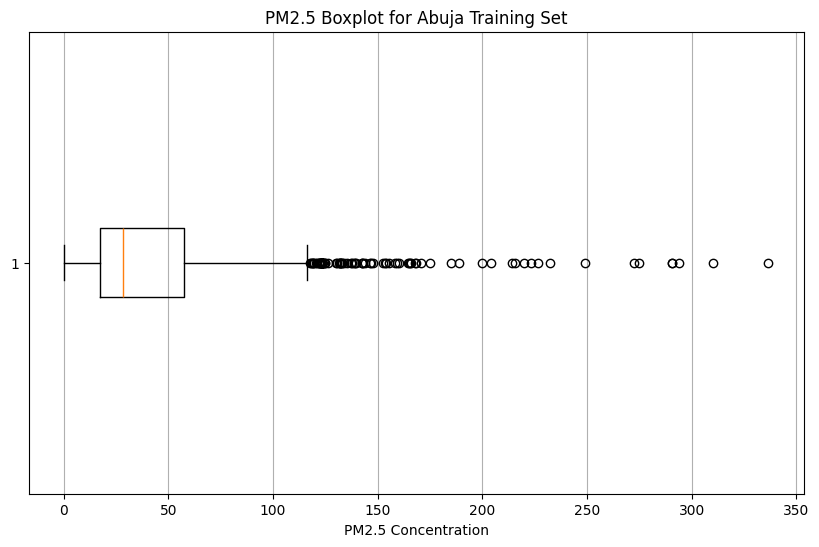

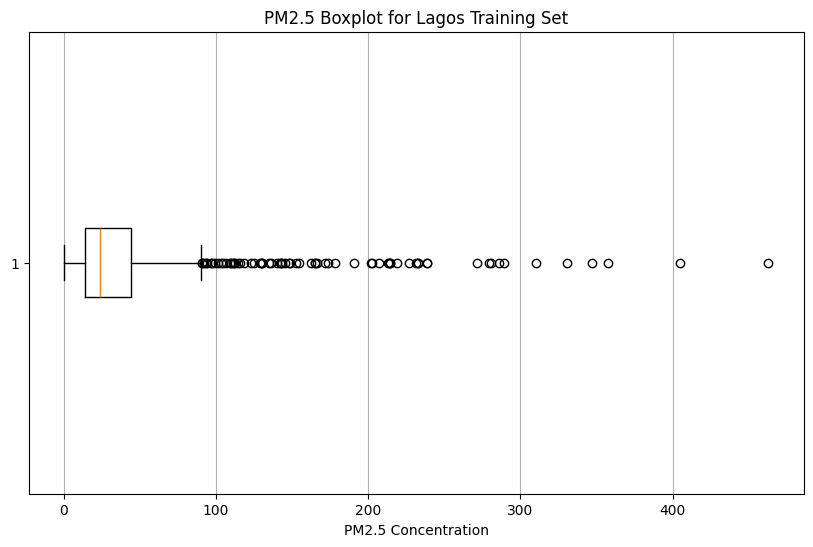

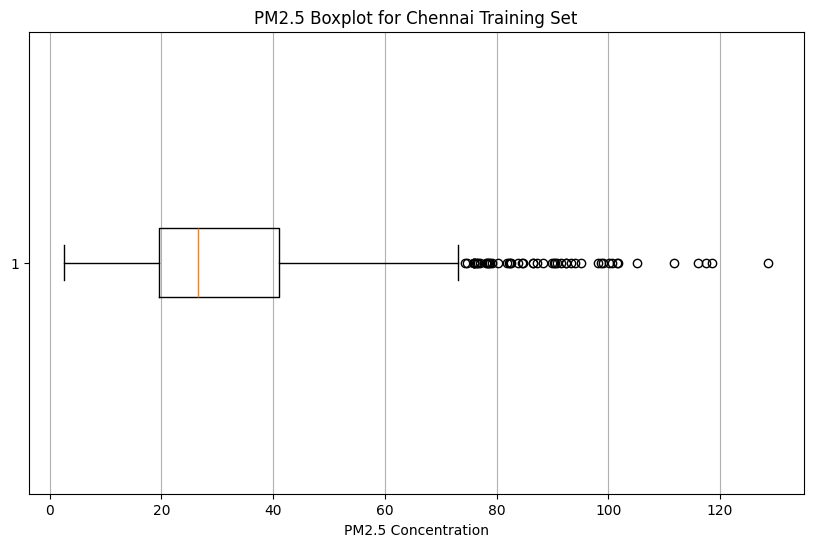

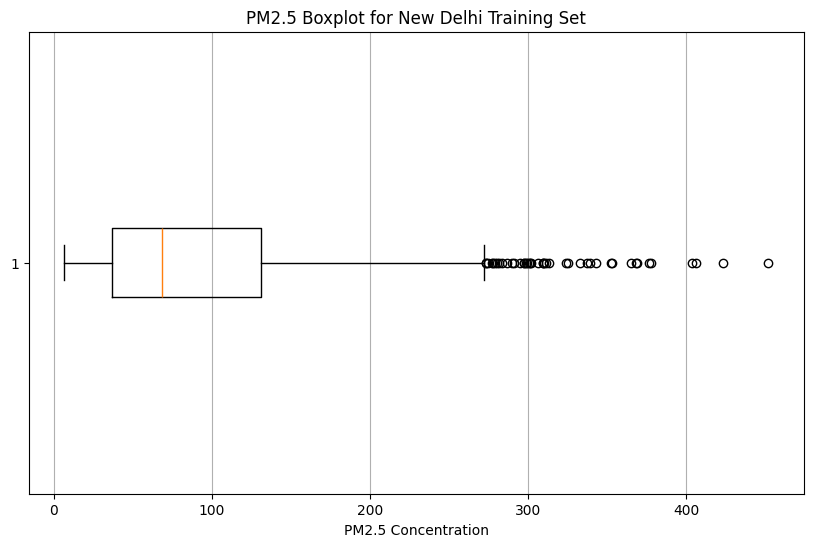

In [36]:
#plot a boxplot for PM2.5 values in the training sets
def plot_pm25_boxplot(df, city_name):
    """
    Plots a boxplot for PM2.5 values in the training set.
    """
    plt.figure(figsize=(10, 6))
    plt.boxplot(df['pm25'], vert=False)
    plt.title(f'PM2.5 Boxplot for {city_name} Training Set')
    plt.xlabel('PM2.5 Concentration')
    plt.grid(axis='x')
    plt.show()
# Plot boxplots for each city's training set
plot_pm25_boxplot(abuja_train_imp, "Abuja")
plot_pm25_boxplot(lagos_train_imp, "Lagos")
plot_pm25_boxplot(chennai_train_imp, "Chennai")
plot_pm25_boxplot(newdelhi_train_imp, "New Delhi")

In [37]:
#describe the training sets
def describe_training_set(df, city_name):
    """
    Prints descriptive statistics for the training set.
    """
    print(f"Descriptive statistics for {city_name} training set:")
    print(df.describe())
    print("\nUnique values in categorical columns:")
    for col in df.select_dtypes(include=['object']).columns:
        print(f"{col}: {df[col].nunique()} unique values")
    print("\n")

# Describe each city's training set
describe_training_set(abuja_train_imp, "Abuja")
describe_training_set(lagos_train_imp, "Lagos")
describe_training_set(chennai_train_imp, "Chennai")
describe_training_set(newdelhi_train_imp, "New Delhi")


Descriptive statistics for Abuja training set:
                      date         pm25  temp_avg_day  wind_u_avg_day  \
count                 1095  1095.000000   1095.000000     1095.000000   
mean   2022-07-02 00:00:00    46.072479    300.054905        0.084089   
min    2021-01-01 00:00:00     0.000000    294.517639       -2.135548   
25%    2021-10-01 12:00:00    17.245833    298.248826       -0.479380   
50%    2022-07-02 00:00:00    28.455556    300.229226        0.191479   
75%    2023-04-01 12:00:00    57.255556    301.571521        0.696268   
max    2023-12-31 00:00:00   336.645833    305.788806        2.042587   
std                    NaN    45.731695      2.232643        0.768593   

       wind_v_avg_day  dewpoint_avg_day  precip_avg_day  temp_avg_night  \
count     1095.000000       1095.000000    1.095000e+03     1095.000000   
mean         0.373616        289.100109    1.474585e-03      298.135227   
min         -2.023772        268.243839    0.000000e+00      293.65921

In [38]:
#find which dates have PM2.5 values below 1 µg/m³
def find_low_pm25_dates(df, threshold=1):
    """
    Finds dates where PM2.5 values are below a specified threshold.
    """
    low_pm25_dates = df[df['pm25'] < threshold]['date'].dt.date.unique()
    return low_pm25_dates
# Find low PM2.5 dates for each city's training, validation and test sets
#train
low_pm25_abuja_train = find_low_pm25_dates(abuja_train_imp)
low_pm25_lagos_train = find_low_pm25_dates(lagos_train_imp)
low_pm25_chennai_train = find_low_pm25_dates(chennai_train_imp)
low_pm25_newdelhi_train = find_low_pm25_dates(newdelhi_train_imp)

#validation
low_pm25_abuja_valid = find_low_pm25_dates(abuja_valid_imp)
low_pm25_lagos_valid = find_low_pm25_dates(lagos_valid_imp)
low_pm25_chennai_valid = find_low_pm25_dates(chennai_valid_imp)
low_pm25_newdelhi_valid = find_low_pm25_dates(newdelhi_valid_imp)

#test
low_pm25_abuja_test = find_low_pm25_dates(abuja_test_imp)
low_pm25_lagos_test = find_low_pm25_dates(lagos_test_imp)
low_pm25_chennai_test = find_low_pm25_dates(chennai_test_imp)
low_pm25_newdelhi_test = find_low_pm25_dates(newdelhi_test_imp)

# Print low PM2.5 dates for each city
print("Low PM2.5 dates in Abuja Train:", low_pm25_abuja_train)
print("Low PM2.5 dates in Lagos Train:", low_pm25_lagos_train)
print("Low PM2.5 dates in Chennai Train:", low_pm25_chennai_train)
print("Low PM2.5 dates in New Delhi Train:", low_pm25_newdelhi_train)
print("Low PM2.5 dates in Abuja Valid:", low_pm25_abuja_valid)
print("Low PM2.5 dates in Lagos Valid:", low_pm25_lagos_valid)  
print("Low PM2.5 dates in Chennai Valid:", low_pm25_chennai_valid)
print("Low PM2.5 dates in New Delhi Valid:", low_pm25_newdelhi_valid)
print("Low PM2.5 dates in Abuja Test:", low_pm25_abuja_test)
print("Low PM2.5 dates in Lagos Test:", low_pm25_lagos_test)
print("Low PM2.5 dates in Chennai Test:", low_pm25_chennai_test)
print("Low PM2.5 dates in New Delhi Test:", low_pm25_newdelhi_test)


Low PM2.5 dates in Abuja Train: [datetime.date(2022, 1, 5) datetime.date(2022, 1, 12)
 datetime.date(2022, 4, 23) datetime.date(2022, 4, 24)
 datetime.date(2023, 7, 5)]
Low PM2.5 dates in Lagos Train: [datetime.date(2021, 12, 20) datetime.date(2021, 12, 21)
 datetime.date(2021, 12, 22) datetime.date(2021, 12, 23)
 datetime.date(2021, 12, 24) datetime.date(2021, 12, 25)
 datetime.date(2021, 12, 26) datetime.date(2021, 12, 27)
 datetime.date(2021, 12, 28) datetime.date(2021, 12, 29)
 datetime.date(2021, 12, 30) datetime.date(2021, 12, 31)
 datetime.date(2022, 1, 1) datetime.date(2022, 1, 2)
 datetime.date(2022, 1, 3) datetime.date(2023, 1, 12)
 datetime.date(2023, 1, 13) datetime.date(2023, 10, 5)
 datetime.date(2023, 10, 6) datetime.date(2023, 10, 7)
 datetime.date(2023, 10, 8)]
Low PM2.5 dates in Chennai Train: []
Low PM2.5 dates in New Delhi Train: []
Low PM2.5 dates in Abuja Valid: []
Low PM2.5 dates in Lagos Valid: []
Low PM2.5 dates in Chennai Valid: []
Low PM2.5 dates in New Delhi

The Dataset shows these dates as "Valid" although it is strange that Lagos and Abuja with notooriously high PM2.5 values had these values (some days having zero readings). However, very heavy rains and strong winds can also clear up particulaate matter temporarily. I will check the wind speeds for a few of these days and percipitation to confirm this assumption. 

In [39]:
#check temperature, wind speed, and percipitation for low PM2.5 dates
def check_weather_on_low_pm25(df, low_pm25_dates):
    low_pm25_df = df[df['date'].dt.date.isin(low_pm25_dates)].copy()
    
    if low_pm25_df.empty:
        print("No low PM2.5 dates found in the DataFrame.")
        return pd.DataFrame()

    weather_columns = ['pm25','date', 'temp_avg_day', 'wind_u_avg_day', 'wind_v_avg_day', 'precip_avg_day']
    return low_pm25_df[weather_columns]


# Check weather for low PM2.5 dates in Abuja and Lagos training set
abuja_low_pm25_weather = check_weather_on_low_pm25(abuja_train_imp, low_pm25_abuja_train)
lagos_low_pm25_weather = check_weather_on_low_pm25(lagos_train_imp, low_pm25_lagos_train)

print("Abuja Low PM2.5 Weather Data:")
print(abuja_low_pm25_weather.head())
print("Lagos Low PM2.5 Weather Data:")
print(lagos_low_pm25_weather.head())


Abuja Low PM2.5 Weather Data:
         pm25       date  temp_avg_day  wind_u_avg_day  wind_v_avg_day  \
369  0.800000 2022-01-05    299.777343       -0.367188       -0.448197   
376  0.906250 2022-01-12    301.278418       -0.439806        0.288673   
477  0.000000 2022-04-23    302.410690        0.843361        0.684323   
478  0.000000 2022-04-24    302.129860        0.991287        1.376722   
915  0.970833 2023-07-05    297.798799        0.557018        1.153156   

     precip_avg_day  
369    0.000000e+00  
376    1.075367e-07  
477    4.986415e-04  
478    4.739423e-04  
915    4.291091e-04  
Lagos Low PM2.5 Weather Data:
         pm25       date  temp_avg_day  wind_u_avg_day  wind_v_avg_day  \
353  0.812500 2021-12-20    300.927051       -0.355535        0.228269   
354  0.483333 2021-12-21    301.077308       -0.400682        0.074521   
355  0.554167 2021-12-22    300.948941       -0.004826        0.563225   
356  0.537500 2021-12-23    301.031808        0.410076        0.969

In [40]:
#check for other days above the threshold
def check_weather_on_high_pm25(df, low_pm25_dates, threshold=1):
    """
    Checks weather data for days where PM2.5 is above a threshold.
    """
    high_pm25_df = df[~df['date'].dt.date.isin(low_pm25_dates) & (df['pm25'] > threshold)].copy()
    

    weather_columns = ['pm25', 'date', 'temp_avg_day', 'wind_u_avg_day', 'wind_v_avg_day', 'precip_avg_day']
    return high_pm25_df[weather_columns]
# Check weather for high PM2.5 dates in Abuja and Lagos training set
abuja_high_pm25_weather = check_weather_on_high_pm25(abuja_train_imp, low_pm25_abuja_train)
lagos_high_pm25_weather = check_weather_on_high_pm25(lagos_train_imp, low_pm25_lagos_train)

#print to see the first few rows of high PM2.5 weather data
print("Abuja High PM2.5 Weather Data:")
print(abuja_high_pm25_weather.head())
print("Lagos High PM2.5 Weather Data:")
print(lagos_high_pm25_weather.head())

Abuja High PM2.5 Weather Data:
    pm25       date  temp_avg_day  wind_u_avg_day  wind_v_avg_day  \
0  123.6 2021-01-01    301.567823       -0.693885        0.120951   
1  123.6 2021-01-02    301.465723       -0.268042        0.403048   
2  123.6 2021-01-03    301.870706       -0.478906        0.046959   
3  123.6 2021-01-04    302.196818       -1.089470       -0.605244   
4  123.6 2021-01-05    302.455898       -1.579624       -0.082491   

   precip_avg_day  
0    3.720853e-08  
1    0.000000e+00  
2    2.861023e-07  
3    3.911554e-07  
4    4.616876e-07  
Lagos High PM2.5 Weather Data:
        pm25       date  temp_avg_day  wind_u_avg_day  wind_v_avg_day  \
0  76.743478 2021-01-01    301.325093        2.079953        1.765790   
1  45.662500 2021-01-02    301.397833        2.272797        2.006946   
2  33.662500 2021-01-03    301.146858        1.876398        2.195090   
3  34.333333 2021-01-04    301.420764        1.799069        1.830127   
4  33.787500 2021-01-05    301.292625 

In Abuja and Lagos, for days with PM2.5 <1 µg/m³, the winds show consistently light speeds (<1.5 m/s) with variable directions, compared to normal days with higher PM2.5 values (up to 123 µg/m³ in Abuja, 76 in Lagos) which feature stronger winds (>2 m/s in Lagos; >1.5 m/s in Abuja) often from northeasterly directions.
This could prove validity of readings so I will retain these values.

In [ ]:
#export imputed data to CSV files
def export_to_csv(df, filename):

    df.to_csv(filename, index=False)
    print(f"Exported {filename} with shape {df.shape}")
# Export each city's imputed data
export_to_csv(abuja_train_imp, "Abuja_train_imp.csv")   
export_to_csv(abuja_valid_imp, "Abuja_valid_imp.csv")
export_to_csv(abuja_test_imp, "Abuja_test_imp.csv")     
export_to_csv(lagos_train_imp, "Lagos_train_imp.csv")
export_to_csv(lagos_valid_imp, "Lagos_valid_imp.csv")
export_to_csv(lagos_test_imp, "Lagos_test_imp.csv")
export_to_csv(chennai_train_imp, "Chennai_train_imp.csv")
export_to_csv(chennai_valid_imp, "Chennai_valid_imp.csv")
export_to_csv(chennai_test_imp, "Chennai_test_imp.csv")
export_to_csv(newdelhi_train_imp, "NewDelhi_train_imp.csv")
export_to_csv(newdelhi_valid_imp, "NewDelhi_valid_imp.csv")
export_to_csv(newdelhi_test_imp, "NewDelhi_test_imp.csv")


Exported Abuja_train_imp.csv with shape (1095, 52)
Exported Abuja_valid_imp.csv with shape (182, 52)
Exported Abuja_test_imp.csv with shape (184, 52)
Exported Lagos_train_imp.csv with shape (1095, 52)
Exported Lagos_valid_imp.csv with shape (182, 52)
Exported Lagos_test_imp.csv with shape (184, 52)
Exported Chennai_train_imp.csv with shape (1095, 52)
Exported Chennai_valid_imp.csv with shape (182, 52)
Exported Chennai_test_imp.csv with shape (184, 52)
Exported NewDelhi_train_imp.csv with shape (1095, 52)
Exported NewDelhi_valid_imp.csv with shape (182, 52)
Exported NewDelhi_test_imp.csv with shape (184, 52)


In [44]:
#export raw flagged data to CSV files
def export_raw_flagged_to_csv(df, filename):
    df.to_csv(filename, index=False)
    print(f"Exported {filename} with shape {df.shape}")
# Export each city's raw flagged data
export_raw_flagged_to_csv(abuja_train_raw_flagged, "Abuja_train_raw_flagged.csv")
export_raw_flagged_to_csv(abuja_valid_raw_flagged, "Abuja_valid_raw_flagged.csv")
export_raw_flagged_to_csv(abuja_test_raw_flagged, "Abuja_test_raw_flagged.csv")
export_raw_flagged_to_csv(lagos_train_raw_flagged, "Lagos_train_raw_flagged.csv")
export_raw_flagged_to_csv(lagos_valid_raw_flagged, "Lagos_valid_raw_flagged.csv")
export_raw_flagged_to_csv(lagos_test_raw_flagged, "Lagos_test_raw_flagged.csv")
export_raw_flagged_to_csv(chennai_train_raw_flagged, "Chennai_train_raw_flagged.csv")
export_raw_flagged_to_csv(chennai_valid_raw_flagged, "Chennai_valid_raw_flagged .csv")
export_raw_flagged_to_csv(chennai_test_raw_flagged, "Chennai_test_raw_flagged.csv")
export_raw_flagged_to_csv(newdelhi_train_raw_flagged, "NewDelhi_train_raw_flagged.csv")
export_raw_flagged_to_csv(newdelhi_valid_raw_flagged, "NewDelhi_valid_raw_flagged.csv")
export_raw_flagged_to_csv(newdelhi_test_raw_flagged, "NewDelhi_test_raw_flagged.csv")

Exported Abuja_train_raw_flagged.csv with shape (1095, 54)
Exported Abuja_valid_raw_flagged.csv with shape (182, 54)
Exported Abuja_test_raw_flagged.csv with shape (184, 54)
Exported Lagos_train_raw_flagged.csv with shape (1095, 54)
Exported Lagos_valid_raw_flagged.csv with shape (182, 54)
Exported Lagos_test_raw_flagged.csv with shape (184, 54)
Exported Chennai_train_raw_flagged.csv with shape (1095, 54)
Exported Chennai_valid_raw_flagged .csv with shape (182, 54)
Exported Chennai_test_raw_flagged.csv with shape (184, 54)
Exported NewDelhi_train_raw_flagged.csv with shape (1095, 54)
Exported NewDelhi_valid_raw_flagged.csv with shape (182, 54)
Exported NewDelhi_test_raw_flagged.csv with shape (184, 54)
